# Задание 3. Применение RNN для прогнозирования отношения в рецензиях на фильмы


## Кодирование данных и разделение на пакеты

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow import keras
from keras import Sequential
from keras.layers import Embedding, Dense, Bidirectional, LSTM 
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

2023-05-31 21:18:43.426070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 21:18:44.055101: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-05-31 21:18:44.055166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-05-31 21:18:44.055185: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
df = pd.read_csv('movie_data.csv', encoding='utf-8')

**Cоздание набора данных**

In [3]:
target = df.pop('sentiment')
ds_raw = tf.data.Dataset.from_tensor_slices((df.values, target.values))

for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


2023-05-31 21:18:53.273656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-05-31 21:18:53.273691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Proton
2023-05-31 21:18:53.273698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Proton
2023-05-31 21:18:53.273779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-05-31 21:18:53.273799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-05-31 21:18:53.273803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.105.17
2023-05-31 21:18:53.275367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network L

In [4]:
tf.random.set_seed(1)
ds_raw = ds_raw.shuffle(50000, reshuffle_each_iteration=False)

ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

**Нахождение уникальных лексем**

In [5]:
tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)

print('Размер словаря: ', len(token_counts))

Размер словаря:  87007


**Кодирование уникальных лексем в виде целых чисел**

In [6]:
encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)
def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

In [7]:
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label],
                        Tout = (tf.int64, tf.int64))


In [8]:
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

**Просмотр**

In [9]:
tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Длина последовательности: ', example[0].shape)

Длина последовательности:  (24,)
Длина последовательности:  (179,)
Длина последовательности:  (262,)
Длина последовательности:  (535,)
Длина последовательности:  (130,)


### Разделение на пакеты

В качестве примера извлечем небольшой поднабор и разделим его на пакеты размера 4 с помощью padded_batch():

In [10]:
ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Размер индивидуального элемента: ', example[0].shape)

Размер индивидуального элемента:  (119,)
Размер индивидуального элемента:  (688,)
Размер индивидуального элемента:  (308,)
Размер индивидуального элемента:  (204,)
Размер индивидуального элемента:  (326,)
Размер индивидуального элемента:  (240,)
Размер индивидуального элемента:  (127,)
Размер индивидуального элемента:  (453,)


In [11]:
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], [])
)
for batch in ds_batched:
    print('Размерность пакета: ', batch[0].shape)

Размерность пакета:  (4, 688)
Размерность пакета:  (4, 453)


Теперь разделим наши выборки на пакеты размера 32

In [12]:
train_data = ds_train.padded_batch(32, padded_shapes=([-1], []))
valid_data = ds_valid.padded_batch(32, padded_shapes=([-1], []))
test_data = ds_test.padded_batch(32, padded_shapes=([-1], []))

Рассмотрим размерности 

In [13]:
for batch in train_data.take(5):
    print('Размерность пакета: ', batch[0].shape)

Размерность пакета:  (32, 715)
Размерность пакета:  (32, 873)
Размерность пакета:  (32, 848)
Размерность пакета:  (32, 782)
Размерность пакета:  (32, 509)


## Реализация многослойной RNN со слоем LSTM в оболочке Bidirectional

In [14]:
embedding_dim = 20
vocab_size = len(token_counts) + 2

tf.random.set_seed(1)

bi_lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        name='embed_layer'),
    Bidirectional(
        LSTM(64, name='lstm-layer'),
        name='bidir-lstm'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

bi_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embed_layer (Embedding)     (None, None, 20)          1740180   
                                                                 
 bidir-lstm (Bidirectional)  (None, 128)               43520     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________


## Пакетное обучение

In [15]:
bi_lstm_model.compile(
    optimizer=Adam(1e-3),
    loss=BinaryCrossentropy(from_logits=False), 
    metrics=['accuracy'])

history = bi_lstm_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=5)

Epoch 1/5
625/625 [==============================] - 133s 210ms/step - loss: 0.6516 - accuracy: 0.6030 - val_loss: 0.6534 - val_accuracy: 0.6040
Epoch 2/5
625/625 [==============================] - 135s 217ms/step - loss: 0.5855 - accuracy: 0.6779 - val_loss: 0.4633 - val_accuracy: 0.7924
Epoch 3/5
625/625 [==============================] - 142s 227ms/step - loss: 0.2748 - accuracy: 0.8914 - val_loss: 0.4080 - val_accuracy: 0.8520
Epoch 4/5
625/625 [==============================] - 136s 217ms/step - loss: 0.1429 - accuracy: 0.9496 - val_loss: 0.4865 - val_accuracy: 0.8154
Epoch 5/5
625/625 [==============================] - 137s 219ms/step - loss: 0.1070 - accuracy: 0.9620 - val_loss: 0.4586 - val_accuracy: 0.8292


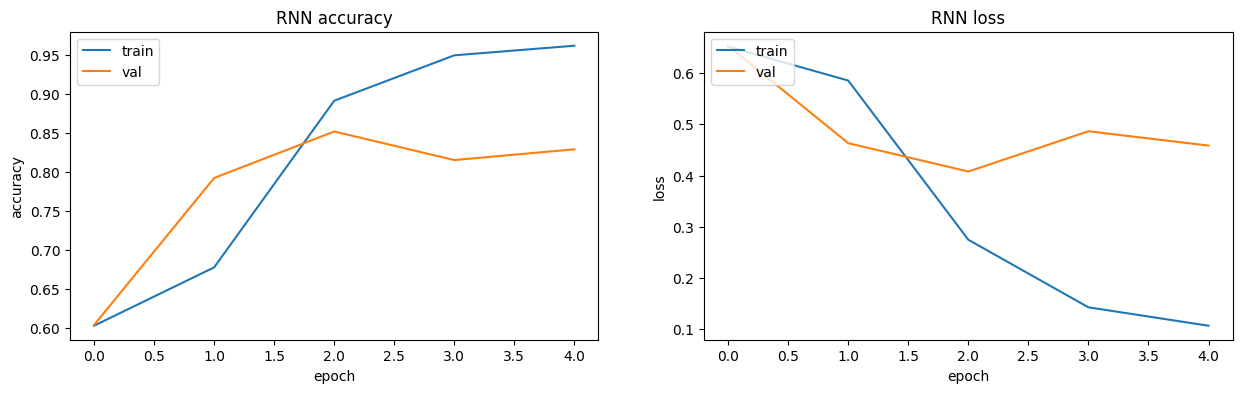

In [19]:
plt.figure(figsize = (15, 4))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc ='upper left')
ax.set(title='RNN accuracy', xlabel = 'epoch', ylabel='accuracy')

ax = plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'], loc ='upper left')
ax.set(title='RNN loss', xlabel = 'epoch', ylabel='loss')

plt.show()

## Оценка на тестовой выборке

In [20]:
test_results=bi_lstm_model.evaluate(test_data)
print('{:.2f}%'.format(test_results[1]*100) )

782/782 [==============================] - 49s 62ms/step - loss: 0.4529 - accuracy: 0.8294
82.94%
